# Probability and statistics tools and demonstrations
By <a href="https://www.maxkapur.com/">Max Kapur</a>. Updated Dec. 9, 2019.

These notes are written at the level of the concepts they address. That is, I try not to reference concepts from later sections when solving problems from early in the text.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom
from scipy.stats import chi2, gamma
from scipy.optimize import minimize
from math import factorial

## A detailed look at independent and dependent probability
Reference: Robert V. Hogg et al., *Probability and Statistical Inference* 9e, section 1.4.

A homework problem from this section reads,

> An urn contains 10 red and 10 white balls. The balls are drawn from the urn at random, one at a time. Find the probabilities that the fourth white ball is the fourth, fifth, sixth, or seventh ball drawn if the sampling is done
>
> <ol style="list-style-type: upper-alpha;"><li>With replacement.</li><li>Without replacement.</li><li>In the World Series, the American League (red) and National League (white) teams play until one team wins four games. Do you think that the urn model presented in this exercise could be used to describe the probabilities of a 4-, 5-, 6-, or 7-game series? (Note that either &ldquo;red&rdquo; or &ldquo;white&rdquo; could win.) If your answer is yes, would you choose sampling with or without replacement in your model? (For your information, the numbers of 4-, 5-, 6-, and 7-game series, up to and including 2012, were 21, 24, 23, 36. This ignores games that ended in a tie, which occurred in 1907, 1912, and 1922. Also, it does not include the 1903 and 1919&ndash;1921 series, in which the winner had to take five out of nine games. The World Series was canceled in 1994.)</li></ol>

I will use Python to demonstrate how list comprehensions can cut down on the busy work otherwise required by this problem. (Take a look at the ratio of text to code in this section.)

First, let&rsquo;s think about what it means for the fourth white ball to occur on the *n*th trial.

There is only one way for the fourth white ball to occur on the fourth trial: all of the preceding balls must have also been white. For a reason that will be clear in a moment, we can express this one possible arrangement as the binomial coefficient $1 = \binom{3}{3}$.

For the fourth white ball to occur on the fifth trial, there must have been exactly three white balls on trials one through four (any more, and the experiment has terminated; any fewer, and we&rsquo;ll need to run more trials). There are $\binom{4}{3} = 4$ ways for that to happen:


$$\text{white, white, white, red}\\ \text{white, white, red, white} \\\text{white, red, white, white} \\\text{red, white, white, white}$$

Likewise, if we draw the fourth white ball on trial six, there are $\binom{5}{3}$ ways for there to have been exactly three white balls drawn in the preceding five trials, and so on. 

The number of &ldquo;ways&rdquo; for the fourth white ball to occur on the *n*th trial is then $\binom{n-1}{3}$. Let&rsquo;s store those values for $n = \{4,5,6,7\}$ in the variable <code>ways</code>. We will need these coefficients to answer both parts of the question.

In [2]:
ways = np.array([binom(n-1,3) for n in range(4,8)])
ways

array([ 1.,  4., 10., 20.])

#### Part A

For the fourth white ball to occur on a certain trial, we need to stick exactly to the sequences enumerated above, then complete each sequence by drawing a white ball on the *n*th trial itself. In part A, we are sampling with replacement, so the probability of selecting a given ball on a given trial is always $10/20 = 1/2$. That means that each sequence of length *n* occurs with probability $P(S_n) = (1/2)^n$. Let&rsquo;s store these probabilities in another vector, <code>psn</code>.

Note that $S_n$ denotes the probability of *a given particular* sequence of length *n* occurring, not the (higher) probability of &ldquo;any sequence containing four white outcomes, with the white outcome coming up last.&rdquo;

In [3]:
psn = np.array([0.5**n for n in range(4,8)])
psn

array([0.0625   , 0.03125  , 0.015625 , 0.0078125])

Now, let $A_n$ denote the event of drawing the fourth ball on the *n*th trial, or using the language above, &ldquo;any sequence containing four white outcomes, with the white outcome coming up last.&rdquo; Well, we already figured out the number of length-*n* sequences that fit this description when we created the <code>ways</code> variable. Multiplying those coefficients by the corresponding terms of <code>psn</code> will give us the answer to part A.

In [4]:
ways * psn

array([0.0625 , 0.125  , 0.15625, 0.15625])

This is $\frac{1}{16}, \frac{1}{8}, \frac{5}{32}, \frac{5}{32}$, the answer given in the book. 

However, another way to interpret the question would be to find the probability of the fourth white ball occurring on *any one* of the four trials mentioned. This is $P(A_4 \cup A_5 \cup A_6 \cup A_7 )$. Since the $A_n$ are mutually exclusive (you cannot draw the fourth white ball on trial four and then again on trial five), we know:

$$\begin{align} P(A_4 \cup A_5 \cup A_6 \cup A_7 ) &= P(A_4) + P(A_5) + P(A_6) + P(A_7) \\ &= \binom{3}{3}\left(\frac{1}{2}\right)^4 + \binom{4}{3}\left(\frac{1}{2}\right)^5 + \binom{5}{3}\left(\frac{1}{2}\right)^6 + \binom{6}{3}\left(\frac{1}{2}\right)^7 \\ & = \frac{1}{2} \end{align} $$

This is just the dot product of our <code>ways</code> and <code>psn</code> variables.

In [5]:
ways @ psn

0.5

Doubling this number shows the probability&mdash;100%&mdash;that four white balls *or* four red balls will occur within seven trials, proving that the World Series never needs to run beyond seven games (disregarding ties).

#### Part B
This is a little trickier. We should start by noticing that the combinations that will yield terminating sequences are exactly the same. That is, we can reuse our <code>ways</code> variable, and what we need to find now is $T_n$, the probability of a given length-*n* sequence containing four white balls and $n-4$ red balls. 

In the $n=4$ case, there is only one possible such sequence: $\text{white, white, white, white}$. Since we lose one white ball from the urn each time we draw one, we get a factorialish expression: 

$$ P(T_4) = \frac{10}{20} \cdot \frac{9}{19} \cdot \frac{8}{18} \cdot \frac{7}{17} $$

For a longer sequence, the denominator will look similar: it will have the first *n* terms of $20!$. The numerator requires a bit of attention. $10 \cdot 9 \cdot 8 \cdot 7$ will stay there, but instead of continuing to decrease, the red balls in the sequence deplete their seperate supply of ten. So, for example, 

$$P(T_6) = \left( \frac{10}{20} \cdot \frac{9}{19} \cdot \frac{8}{18} \cdot \frac{7}{17} \right) \cdot \left( \frac{10}{16} \cdot \frac{9}{15} \right) $$

This corresponds to the sequence $\text{white, white, white, white, red, red}$. Technically, this sequence would have terminated at the fourth trial, but rearranging the sequence of draws only rearranges the numerator of this calculation, leaving the value of $T_6$ unchanged. Thinking hard about factorials reveals an expression for $T_n$:

$$P(T_n) = \frac{(20 - n)!}{20!} \cdot \frac{10!}{6!} \cdot  \frac{10!}{(14-n)!}$$

Let&rsquo;s put $P(T_n)$ for $n = \{4,5,6,7\}$ into the variable <code>ptn</code>. These values will replace the $(1/2)^n$ terms we saw in part A. 

In [7]:
d = factorial(10)*factorial(10) / (factorial(20) * factorial(6))
ptn = np.array([d * factorial(20-n) / factorial(14-n) for n in range(4,8)])
ptn

array([0.04334365, 0.02708978, 0.01625387, 0.00928793])

Just as above, we can answer part B with term-by-term product of <code>ways</code> and <code>ptn</code>.

In [8]:
ways * ptn

array([0.04334365, 0.10835913, 0.1625387 , 0.18575851])

The textbook gives $\frac{14}{323}, \frac{35}{323}, \frac{105}{646}, \frac{60}{323}$, which is the same.

We might also choose to give the sum of these probabilities, or the probability that the fourth white ball occurs before the eighth trial. If we did things right, this should also be 0.5, because of the aforementioned symmetry between the white and red versions of this problem.

In [12]:
ways @ ptn

0.5

#### Part C

Before answering the question as posed, let&rsquo;s consider the two models we&rsquo;ve created. In part A, we replaced the balls after pulling them, meaning that each trial was independent. In part B, the probability of pulling a white or red ball depends on how many balls have been taken out so far. If we&rsquo;ve already removed three white balls, then the urn contains only seven white balls and ten red ones; a red one is more likely on our next pull.

The self-correcting nature of the dependent version of this problem is evident in the graph below. Since red balls become more likely when white is &ldquo;in the lead,&rdquo; the likelihood of it taking seven trials to get four red balls is higher. Notice how the purple bars increase steadily in height, while the green ones reach a plateau.

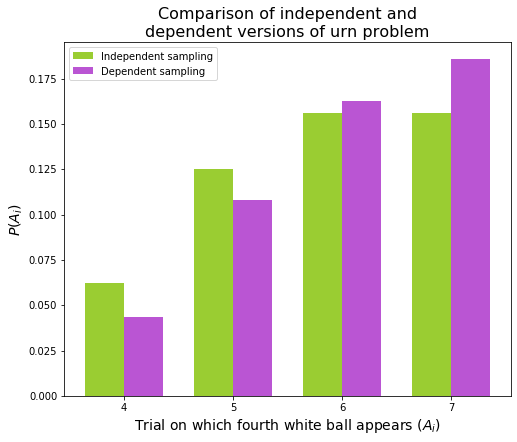

In [44]:
x=np.arange(4,8)
width=0.36
x1 = x - width/2
x2 = x + width/2


plt.figure(figsize=(8,6.5))
plt.bar(x=x1,height=ways*psn,width=width,color='yellowgreen',label='Independent sampling')
plt.bar(x=x2,height=ways*ptn,width=width,color='mediumorchid',label='Dependent sampling')

plt.xlabel(r'Trial on which fourth white ball appears ($A_i$)',size=14)
plt.ylabel(r'$P(A_i)$',size=14)
plt.title('Comparison of independent and\ndependent versions of urn problem',size=16)
plt.xticks(x)
plt.legend()

My intuition says that the independent model should be a decent reflection of what happens in the World Series. While the relative skill of the teams may be different (white probably doesn&rsquo;t have an exactly 50% chance of winning), it doesn&rsquo;t seem to me that each team is drawing on a finite supply of wins or that their performance will deteriorate the more games they win.

On the other hand, perhaps there is an underdog phenomenon in which teams that are falling behind tend to exert themselves in hopes of a comeback victory. 

On a third hand, perhaps losing teams tend to lose hope and give up after a few early losses.

If either of the previous two assertions are true, then we must discard the independent model. However, there are all sorts of dependent models possible, and the one we created above may be even worse than the independent model. In the end, neither model is suited to the real data that the textbook provides. Let&rsquo;s add that to our graph, and this time we will double the probabilities obtained in the urn problem to account for the fact that four wins by *either* team ends the World Series:

In [35]:
ws = np.array([21, 24, 23, 36])
# Divide by the sum to get the experimental probability
ws = ws / ws.sum()

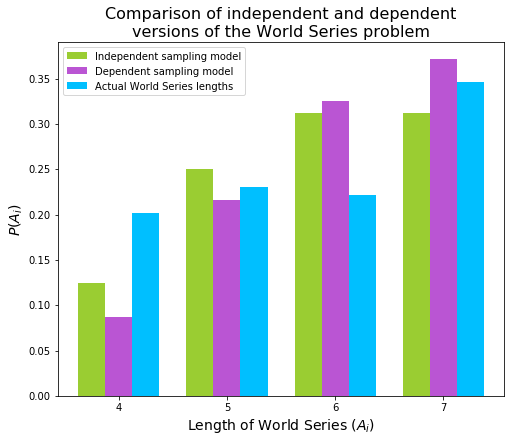

In [47]:
x=np.arange(4,8)
width=0.25
x1 = x - width
x2 = x + width

plt.figure(figsize=(8,6.5))
# Double the models since now we allow either team to win
plt.bar(x=x1,height=2*ways*psn,width=width,color='yellowgreen',label='Independent sampling model')
plt.bar(x=x,height=2*ways*ptn,width=width,color='mediumorchid',label='Dependent sampling model')
plt.bar(x=x2,height=ws,width=width,color='deepskyblue',label='Actual World Series lengths')

plt.xlabel(r'Length of World Series ($A_i$)',size=14)
plt.ylabel(r'$P(A_i)$',size=14)
plt.title('Comparison of independent and dependent\nversions of the World Series problem',size=16)
plt.xticks(x)
plt.legend()

As you can see, neither model accurately predicted the true distribution of World Series lengths. It is probably reasonable to reject the hypothesis that the outcomes of the games in the World Series are completely independent of one another.

## An optimization problem involving the gamma distribution
Reference: Robert V. Hogg et al., *Probability and Statistical Inference* 9e, section 3.2.

Problem 19 reads, 
>  A bakery sells rolls in units of a dozen. The demand $X$ (in 1000 units) for rolls has a gamma distribution with parameters $\alpha=3$, $\theta = 0.5$, where $\theta$ is in units of days per 1000 units of rolls. It costs \\&#36;2 to make a unit that sells for \\&#36;5 on the first day when the rolls are fresh. Any leftover units are sold on the second day for \\&#36;1. How many units should be made to maximize the expected value of the profit?

We can start by setting up the demand function, which is

$$ f(x) = \frac{x^{3 - 1}e^{-x/0.5}}{\Gamma(3)(0.5)^3} = 4x^2e^{-2x}$$
 
Python can construct this gamma function for us using <code>scipy.stats.gamma.pdf</code>. Let&rsquo;s take a look at that.

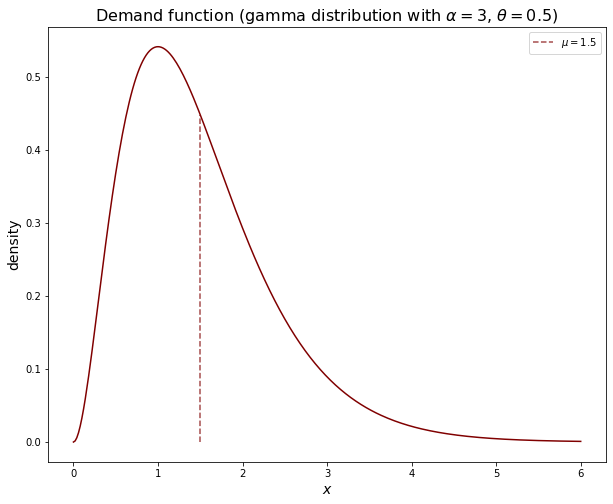

In [7]:
def demand(x):
    return gamma.pdf(x, 3, scale=0.5)

x= np.linspace(0, 6,301)
plt.figure(figsize=(10,8))
plt.title(r'Demand function (gamma distribution with $\alpha=3$, $\theta = 0.5$)',size=16)
plt.xlabel(r'$x$', size=14)
plt.ylabel(r'density', size=14)
plt.plot(x,demand(x), color='maroon')
plt.vlines(1.5,0,demand(1.5),ls='--',color='maroon',alpha=0.7, label=r'$\mu=1.5$')
plt.legend()

Now, we need to set up our profit function. This is a function of $u$, which will denote the number of units we choose to make, and $x$. The function will have two pieces: If $u \lt x$, then the bakery will have leftovers and will need to sell them at reduced profit on the second day. If $u \geq x$, then we will simply sell all of the units at \\$5 each. In either case, we will start by outlaying $2 per unit produced. Then 

$$C(u, x) =
\begin{cases}
-2u + 5u &= 3u,  & u \lt x \\
-2u +5x + (u-x) &= 4x-u, & u \geq x
\end{cases}
$$

Since $x$ is randomly determined, what we want to maximize is the expected value of $C(u,X)$. This we must break into two integrals because the profit function is piecewise.

$$\begin{align}E\left[C(u,X)\right] &= \int_{0}^{\infty}C(u,x) f(x)\,dx \\
& = \int_{0}^{u}(4x-u) 4x^2e^{-2x} \,dx + \int_{u}^{\inf}(3u) 4x^2e^{-2x} \,dx \\
\end{align}$$

Breaking up the integrals further, we discover that the expected profit function is just made up of several gamma cdfs:

$$\begin{align}E\left[C(u,X)\right] &= 6\int_{0}^{u}\frac{16}{6}x^3e^{-2x} \,dx - u \int_{0}^{u} 4x^2e^{-2x} \,dx + 3u\int_{u}^{\inf} 4x^2e^{-2x} \,dx \\
&= 6 G(u) - u F(u) + 3u(1-F(u)) \\
&= 3u + 6 G(u) - 4u F(u)\end{align}$$

where $G(u)$ is the gamma cdf with $\alpha=4$, $\theta = 0.5$ and $F(u)$ is the gamma cdf with $\alpha=3$, $\theta = 0.5$. 

This will make our life a lot easier, since scipy has the gamma cdf built in. To solve algebraically, we&rsquo;d have to apply serial integration by parts to integrate the gamma pdfs, and even that would leave us a messy polynomial whose roots we&rsquo;d have to plug into the computer.

We will define the profit function in Python as <code>expected_profit</code>.

In [8]:
def expected_profit(u):
    return 3*u + 6*gamma.cdf(u, 4, scale=0.5) - 4*u*gamma.cdf(u, 3, scale=0.5)

Now that we have reduced our expected cost to a function of $u$, we need to find the maximum of this function. We know $u$ will be positive, so we will ask scipy to start at $u=0$ and move to the right. Scipy only does minimization, so we feed it the negative of our expected profit function.

In [9]:
out = minimize(lambda u: - expected_profit(u), x0=0)
profit = -out.fun
best_u = out.x[0]
best_u, profit

(1.9602010931382516, 3.3049588923017295)

Looks like the optimal number of units to produce is 1960, corresponding to an expected profit of \\$3305. Let&rsquo;s plot this, and while we&rsquo;re at it, we will correct the scale from showing the units in thousands.

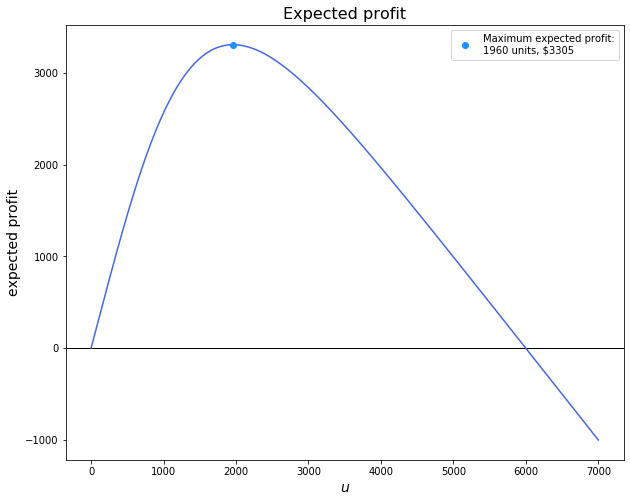

In [14]:
u= np.linspace(0,7,351)

plt.figure(figsize=(10,8))
plt.title(r'Expected profit', size=16)
plt.axhline(color='black',lw=1)
plt.plot(1000 * u, 1000 * expected_profit(u), color='royalblue')
plt.plot(1000 * best_u, 1000 * profit,'o', label='Maximum expected profit:\n1960 units, \\$3305',color='dodgerblue')
plt.xlabel(r'$u$', size=14)
plt.ylabel('expected profit', size=14)
plt.legend(loc='upper right')

This matches the answer given in the text.

## Derivation of the least-squares line of best fit

Reference: Robert V. Hogg et al., *Probability and Statistical Inference* 9e, section 4.2.

Online, you can find <a href="https://brownmath.com/stat/leastsq.htm">many derivations</a> of the least-squares fit for when you are given $X$ and $Y$ as points of data. The textbook asks us to prove this when $X$ and $Y$ are random discrete variables distributed according to some pmf $f(x, y)$. The proof is essentially the same, but the symbols are different. Problem 5:

> Let $X$ and $Y$ be random variables with respective means $\mu_X$ and $\mu_Y$, respective variances $\sigma_X^2$ and $\sigma_Y^2$, and correlation coefficient $\rho$. Fit the line $y = a + bx$ by the method of least squares to the probability distribution by minimizing the expectation $ K(a,b) = E\left[(Y − a − bX)^2 \right]$ with respect to $a$ and $b$. 

We have

$$\begin{align}
K(a,b) & = E\left[(Y − a − bX)^2 \right] \\
& = E(X^2 b^2 - 2 XYb + 2X ab + Y^2 - 2Ya + a^2) \\
& = b^2 (\sigma_X^2 + \mu_X^2) - 2b(\sigma_{XY} + \mu_X \mu_Y) + 2ab\mu_X + \sigma_Y^2 + \mu_Y^2 - 2a\mu_Y + a^2
\end{align}$$

by expanding, distributing, then substituting $E(X^2) = (\sigma_X^2 + \mu_X^2)$, $E(Y^2) = (\sigma_Y^2 + \mu_Y^2)$, and $E(XY) = \sigma_{XY} + \mu_X \mu_Y$.

Let&rsquo;s set the first derivatives to zero and solve for $a$ and $b$.

$$\begin{align}
\frac{\partial K}{\partial a} = 0 & = 2b\mu_X - 2\mu_Y + 2a \\
& \implies \bbox[4px, border: 1px solid black]{ a = \mu_Y - b\mu_X } \\
\frac{\partial K}{\partial b} = 0 & = 2b(\sigma_X^2 + \mu_X^2) - 2 (\sigma_{XY} + \mu_X \mu_Y) + 2a \mu_X \\
& = 2b(\sigma_X^2 + \mu_X^2) - 2 (\sigma_{XY} + \mu_X \mu_Y) + 2(\mu_X \mu_Y - b \mu_X^2) \\
& = 2b\sigma_x^2 - 2\sigma_{XY} \\
& \implies \bbox[4px, border: 1px solid black]{ b = \frac{\sigma_{XY}}{\sigma_X^2} = \rho \frac{\sigma_Y}{\sigma_X} }
\end{align}$$

Then $$\begin{align}
y & = a+bx \\
& = \mu_Y - b\mu_X + bx \\
& = \mu_Y + b(x - \mu_X) \\
& \bbox[4px, border: 1px solid black]{ = \mu_Y + \rho \frac{\sigma_Y}{\sigma_X} (x-\mu_X) }
\end{align}$$

This is the form we are familiar with. Now we just need to show that this is, in fact, a minimum rather than a maximum or saddle point. Taking second derivatives:

$$\begin{align}
\frac{\partial^2 K}{\partial a^2} & = 2 \\
\frac{\partial^2 K}{\partial b^2} & = 2 (\sigma_X^2 + \mu_X^2) \\
\frac{\partial^2 K}{\partial a \, \partial b} & = 2\mu_X \\
\end{align}$$

In multiple variables, the second-derivative test uses the determinant of the Hessian matrix:

$$\begin{align}
\det \begin{bmatrix}
\frac{\partial^2 K}{\partial a^2} & \frac{\partial^2 K}{\partial a \, \partial b} \\
\frac{\partial^2 K}{\partial b \, \partial a} & \frac{\partial^2 K}{\partial b^2} \\
\end{bmatrix} & = 2 \cdot 2 (\sigma_X^2 + \mu_X^2) - (2\mu_X)^2 \\
& = 4\sigma_X^2> 0 \\
\end{align}$$

The determinant is positive, so we have found a minimum.

In [1]:
!jupyter nbconvert stats.ipynb

[NbConvertApp] Converting notebook stats.ipynb to html
[NbConvertApp] Writing 441641 bytes to stats.html
